In [1]:
import os
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.stats import gaussian_kde
from datetime import datetime, date

import sys
sys.path.append('../mchem_functions/')
import multivariate_functions as mvf
import PCA_functions as pcf
import ms_functions_and_defs as msf

In [2]:
replicates = 0
replicate_column = 'replicate_y/n'
binary = 1
normalise = 0
samples_to_exclude = ['SRFA']
molecules_to_exclude = ['C17H28O3S1','C18H30O3S1','C19H32O3S1','C16H26O3S1']

In [3]:
ms_data_dir = '../../Data/MS_data'
ord_table_csv = 'CSV_files/processed_csv_data_dir/overall_intensity_ordination_table.csv'
run_order_csv = 'run_order.csv'

In [4]:
try: os.chdir(ms_data_dir)
except FileNotFoundError: pass

In [5]:
ord_table_df = pd.read_csv(ord_table_csv,index_col=0)
ord_table_df = ord_table_df[ord_table_df[replicate_column]==replicates]
ord_table_df = ord_table_df.drop(columns=replicate_column)

In [6]:
SRFA_ord_table_df = ord_table_df.loc[[x for x in ord_table_df.index if 'SRFA' in x]]
SRFA_ord_table_df = SRFA_ord_table_df.dropna(axis=1, how='all')
SRFA_dates = [x.split('_')[1].replace('-','/') for x in SRFA_ord_table_df.index]

In [7]:
sample_names = list(ord_table_df.index)
for sample in samples_to_exclude:
    for sample2 in [name for name in sample_names if sample in name]:
        sample_names.remove(sample2)
ord_table_df = ord_table_df.loc[sample_names]

ord_table_df = ord_table_df.drop(columns=molecules_to_exclude)
formulae = np.array(ord_table_df.columns)

# ord_table_df

In [8]:
run_order_df = pd.read_csv(run_order_csv)
run_order_df = run_order_df[run_order_df['sample_type']=='sample']
seasonsshort = {'10':'Aut','01':'Win1','02':'Win2'}
run_order_df = run_order_df[run_order_df['sample_name'].str.contains('_i_')]
run_order_df['sample_name'] = ['-'.join([x.split('-')[1],x.split('_')[0].split('-')[-4],seasonsshort[x.split('_')[0].split('-')[-2]]]) for x in run_order_df['sample_name']]
run_order_df = run_order_df.reset_index()
for i in range(len(run_order_df)):
    if run_order_df.loc[i]['sample_name'] not in sample_names:
        run_order_df = run_order_df.drop(index=i)
run_order_df = run_order_df.sort_values('sample_name')[['sample_name','date']]

In [9]:
def BrayCurtis_diss_matr(matrix):

    dist_stacked = []

    S = np.sum(matrix,axis=1)

    for i in range(np.shape(matrix)[0]):
        dist_row = []

        for j in range(np.shape(matrix)[0]):
            C_ij = np.sum(np.min(matrix[[i,j],:],axis=0))
            dist_row.append( 1-( 2*C_ij / (S[i]+S[j]) ) )

        dist_stacked.append(dist_row)
    
    return np.array(dist_stacked)

def formula_dic(str:str):
    '''Indicate with 1 when there is only 1 of a certain atom: H2O would be "H2O1"'''

    elements = re.findall(r'[a-zA-Z]+', str)
    numbers = re.findall(r'[0-9]+', str)
    
    assert len(elements) == len(numbers), 'the number of elements and the number of indeces should match. Indicate with 1 when there is only 1 of a certain atom: H2O would be "H2O1"'

    dic = {}
    for i in range(len(numbers)):
        n = float(numbers[i])
        if n == int(n): n = int(n)
        dic[elements[i]] = int(n)
    
    return dic

def formula_str_plt(dic:dict):
    str = ''
    for e in dic:
        str += f'{e}'
        if dic[e] > 1:
            str += f'$_{{{dic[e]}}}$'
    return str

def matr_colormesh(arr,x=[],y=[],cmap='Grays'):
    fig, ax = plt.subplots()

    mappable = ax.pcolormesh(arr,cmap=cmap)
    fig.colorbar(mappable)

    ax.set_ylim(np.max(ax.get_ylim()),np.min(ax.get_ylim()))

    if len(x) != 0:
        locationsx = np.arange(len(x))+0.5
        ax.set_xticks(locationsx, x, rotation=90, ha='center')
    if len(y) != 0:
        locationsy = np.arange(len(y))+0.5
        ax.set_yticks(locationsy, y)
    
def wetordry(str):
    if str in ([f'HM-{x}' for x in ['A','B','C','D']] + [f'AM-{x}' for x in ['A','B']]):
        return 'dry'
    else: return 'wet'

In [10]:
sample_info = {
    'Site': [],
    'Letter': [],
    'Season': [],
    'Type': [],
    'Wetness':[]
}

for name in sample_names:
    if 'SRFA' in name.upper():
        for key in sample_info:
            sample_info[key].append('SRFA')

    else:
        name = name.split('-')
        sample_info['Site'].append(name[0])
        sample_info['Letter'].append(name[1])
        sample_info['Season'].append(name[2])
        if 'PL' in name: sample_info['Type'].append('PL')
        else: sample_info['Type'].append('PW')
        sample_info['Wetness'].append(wetordry('-'.join(name[:-1])))

for info in sample_info:
    sample_info[info] = np.array(sample_info[info])
# sample_info

In [11]:
# set NaN to 0
ord_table_df = ord_table_df.fillna(0)

# remove formulae where the entire column is zeros
formulae = formulae[~np.all(ord_table_df.to_numpy()==0,axis=0)]
ord_table_df = ord_table_df[formulae]

ord_table_arr = ord_table_df.to_numpy()

In [12]:
# pd.DataFrame(ord_table_arr)

In [13]:
if binary:
    ord_table_arr[np.where(ord_table_arr>0)] = 1
if normalise:
    ord_table_arr = mvf.standardise(ord_table_arr)

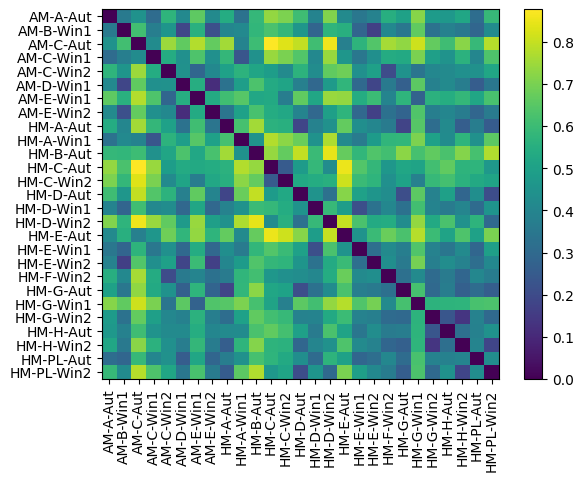

In [14]:
sample_sum = np.sum(ord_table_arr,axis=1)
sample_sum = np.reshape(sample_sum,(len(sample_sum),1))
highest_peak = np.max(ord_table_arr,axis=1)
highest_peak = np.reshape(highest_peak,(len(highest_peak),1))

sum_norm_ord_table_arr = ord_table_arr / highest_peak # or /sample_sum

BC_matrix = BrayCurtis_diss_matr(sum_norm_ord_table_arr)

matr_colormesh(BC_matrix,x=sample_names,y=sample_names,cmap='viridis')

In [15]:
eigvals, _, loadings, coordinates, proportion_explained = mvf.PCoA(BC_matrix,ord_table_arr,number_of_dimensions=6)

Text(0.5, 0, 'Principal coordinate')

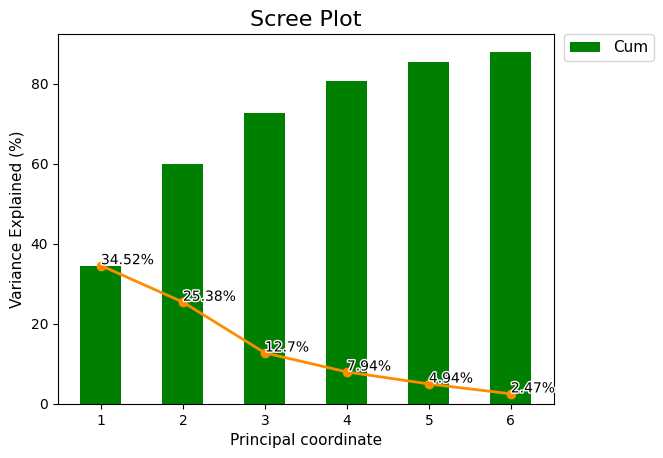

In [16]:
fig_scree, ax_scree = plt.subplots()
pcf.scree_plot(np.arange(1,len(eigvals)+1),proportion_explained,ax=ax_scree)
ax_scree.set_xlabel(f'Principal coordinate')

In [17]:
chosen_PCos = [1,2]

In [18]:
m_shape = {
    'Hare Moss': 'o',
    'Auchencorth Moss': 's',
    'SRFA': '*'
}

seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green

    'SRFA': 'k'
}

wetordry_colours = {
    'wet': 'blue',
    'dry': 'orange',

    'SRFA': 'k'
}

In [19]:
sitelong = [{'AM':'Auchencorth Moss','HM':'Hare Moss','SRFA':'SRFA'}[site] for site in sample_info['Site']]
sample_info['sitelong'] = np.array(sitelong)
sample_info['date'] = run_order_df['date'].to_numpy()

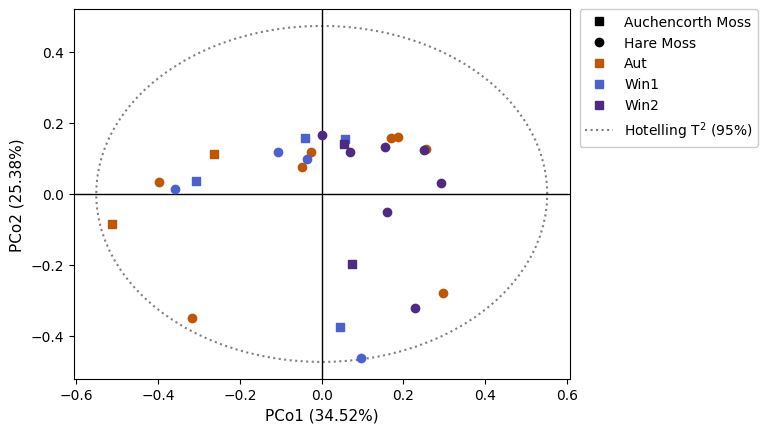

In [20]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(sample_info['sitelong']):
    for season in np.unique(sample_info['Season']):

        idx = np.where((sample_info['sitelong'] == site)&(sample_info['Season'] == season))

        pcf.scores_plot(coordinates[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape[site],c=seasonal_colours[season])
        
pcf.Hotelling(coordinates,chosen_PCos,ax_scores,zorder=-1)

f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(sample_info['sitelong']):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for season in np.unique(sample_info['Season']):
    handles.append(f('s', seasonal_colours[season],ls="none"))
    labels.append(season)

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=16)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig(f'plots/pcoa_plots/scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


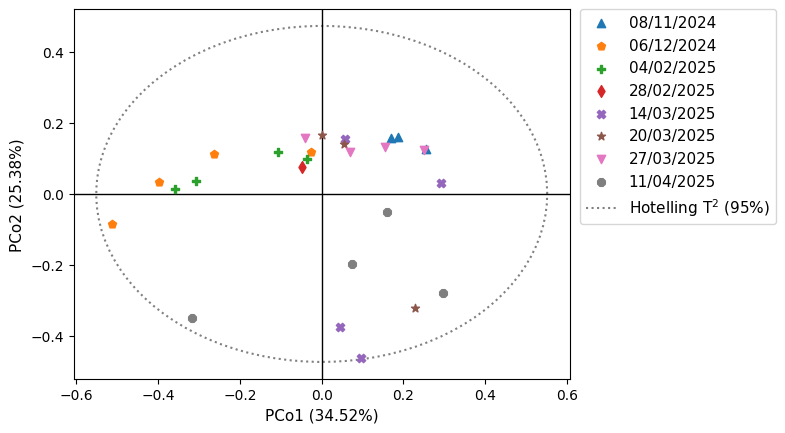

In [21]:
fig_scores, ax_scores = plt.subplots()
sorted_dates = sorted(np.unique(sample_info['date']), key=lambda x: datetime.strptime(x, '%d/%m/%Y'))
datemarkers = ['^','p','P','d','X','*','v','8']
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'] == sorted_dates[i]))
    pcf.scores_plot(coordinates[idx],chosen_PCos,lines=False,ax=ax_scores,label=sorted_dates[i],marker=datemarkers[i])

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(coordinates,chosen_PCos,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig('plots/pcoa_plots/scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

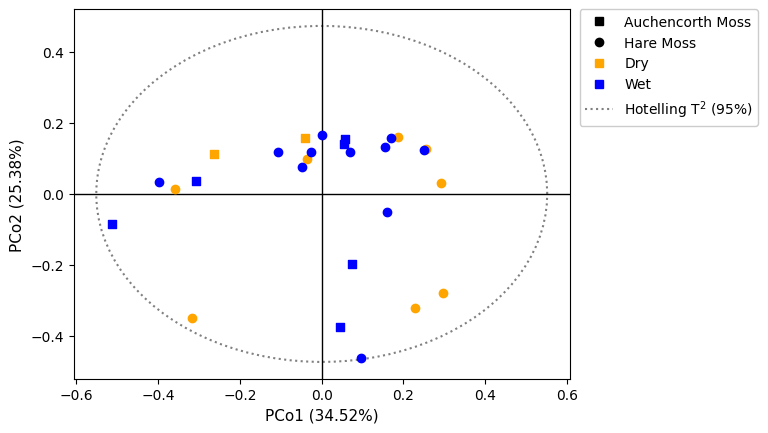

In [22]:
fig_scores, ax_scores = plt.subplots()

for site in np.unique(sample_info['sitelong']):
    for hum in np.unique(sample_info['Wetness']):

        idx = np.where((sample_info['sitelong'] == site)&(sample_info['Wetness'] == hum))

        pcf.scores_plot(coordinates[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape[site],c=wetordry_colours[hum])
        
pcf.Hotelling(coordinates,chosen_PCos,ax_scores,zorder=-1)

f = lambda m,c,ls: ax_scores.plot([],[],marker=m, color=c, ls=ls)[0]
handles = []
labels  = []
for site in np.unique(sample_info['sitelong']):
    handles.append(f(m_shape[site], "k", ls="none"))
    labels.append(site)
for hum in np.unique(sample_info['Wetness']):
    handles.append(f('s', wetordry_colours[hum],ls="none"))
    labels.append(hum.capitalize())

handles += [f('none', "grey",ls=":")]
labels += ['Hotelling T$^{2}$ (95%)']
ax_scores.legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]}')
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]}')

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=16)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig(f'plots/pcoa_plots/scores_wet.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


array([<Axes: ylabel='PC1\nLoadings'>, <Axes: ylabel='PC2\nLoadings'>],
      dtype=object)

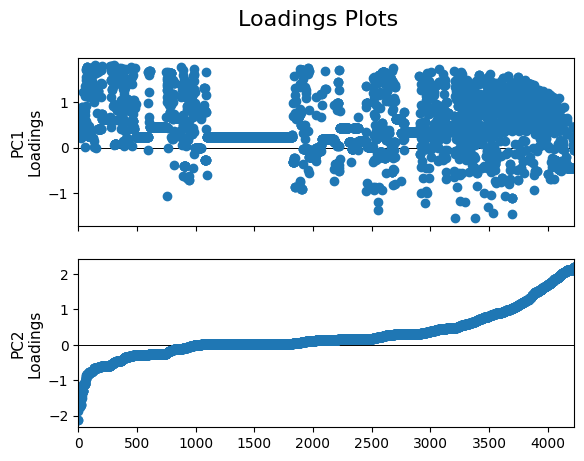

In [23]:
fig_loadings = plt.figure()
ax_loadings = fig_loadings.subplots(len(chosen_PCos),sharex=True)

loadings_order_idx = np.argsort(loadings[:,1])

pcf.loadings_plot(np.arange(len(formulae)),loadings[loadings_order_idx],chosen_PCos,ax=ax_loadings,linestyle='',fig=fig_loadings,
                  marker='o')

# loadings_thresholds = [[-.5,1.5],
#                        [-1,1]]

# for i in range(len(chosen_PCos)):
#     ax_loadings[i].axhline(np.max(loadings_thresholds[i]),c='r')
#     ax_loadings[i].axhline(np.min(loadings_thresholds[i]),c='r')


In [24]:
a = np.array([1,6,4,3,8,2])
np.sort(a)

array([1, 2, 3, 4, 6, 8])

In [25]:
formulae_to_consider = formulae[np.where((loadings[:,chosen_PCos[0]-1]>.8*np.max(loadings[:,chosen_PCos[0]-1]))|
                                         (loadings[:,chosen_PCos[0]-1]<.8*np.min(loadings[:,chosen_PCos[0]-1]))|
                                         (loadings[:,chosen_PCos[1]-1]>.8*np.max(loadings[:,chosen_PCos[1]-1]))|
                                         (loadings[:,chosen_PCos[1]-1]<.8*np.min(loadings[:,chosen_PCos[1]-1])))]

In [26]:
elems = {'C':[],'H':[],'N':[],'O':[],'S':[]}

for f in formulae:
    e_dict_f = msf.MolecFormulaDict(f)
    for e in elems:
        if e in e_dict_f:
            elems[e].append(e_dict_f[e])
        else:
            elems[e].append(0)

In [27]:
elems_df = pd.DataFrame(elems)
elems_df['formulae'] = formulae

In [28]:
elems_df['H/C'] = elems_df['H'] / elems_df['C']
elems_df['O/C'] = elems_df['O'] / elems_df['C']
molecclass_dict = msf.molecclass(elems_df)

In [29]:
idx_to_consider = np.where((loadings[:,chosen_PCos[0]-1]>.8*np.max(loadings[:,chosen_PCos[0]-1]))|
                           (loadings[:,chosen_PCos[0]-1]<.8*np.min(loadings[:,chosen_PCos[0]-1])))

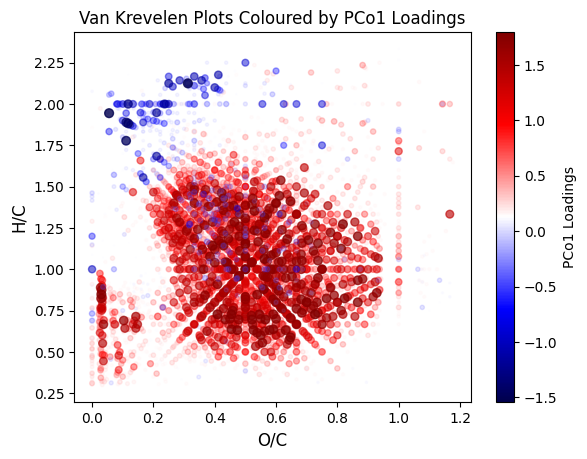

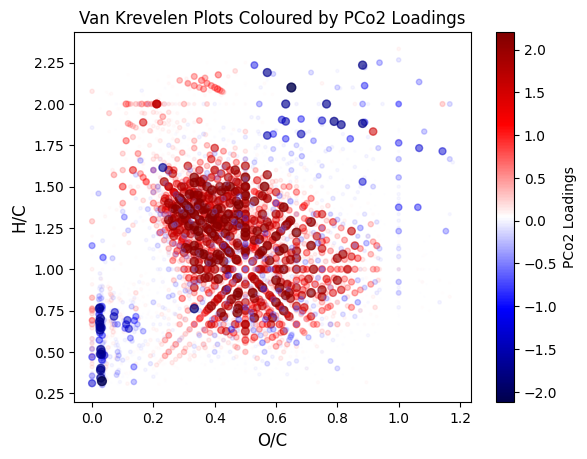

In [30]:
for PCo in chosen_PCos:

    chosen_loadings = loadings[:,PCo-1]
    # chosen_loadings = chosen_loadings[np.where((chosen_loadings>1.5)|
    #                                            (chosen_loadings<-1.5))]
    # sorted_loadings = np.sort(chosen_loadings)
    # chosen_loadings = chosen_loadings[np.where(np.isin(chosen_loadings,sorted_loadings[:1000])|
    #                                            np.isin(chosen_loadings,sorted_loadings[-(1000+1):]))]

    # chosen_loadings = chosen_loadings[np.where((chosen_loadings>.5*np.max(chosen_loadings))|
    #                                            (chosen_loadings<.5*np.min(chosen_loadings)))]

    fig_vkload, ax_vkload = plt.subplots()
    loadings_for_order = chosen_loadings.copy()
    if len(np.where(loadings_for_order<0)[0]) > 0:
        loadings_for_order[np.where(loadings_for_order<0)] /= -np.min(loadings_for_order[np.where(loadings_for_order<0)])
    if len(np.where(loadings_for_order>0)[0]) > 0:
        loadings_for_order[np.where(loadings_for_order>0)] /= np.max(loadings_for_order[np.where(loadings_for_order>0)])

    s = loadings_for_order.copy()
    s_idx = np.arange(len(s))

    if len(np.where(loadings_for_order<0)[0]) > 0 and len(np.where(loadings_for_order>0)[0]) > 0:
        if len((np.where(loadings_for_order<0))[0]) >= len((np.where(loadings_for_order>0))[0]):
            loadings_for_order[np.where(loadings_for_order<0)] /= 100000
        else: loadings_for_order[np.where(loadings_for_order>0)] /= 100000

    order = np.argsort(np.abs(loadings_for_order))
    ordered_loadings = chosen_loadings[order]
    s = np.abs(40*s[order])
    alphas = .8* s / np.max(s)

    mappable = msf.vk_diagram(elems_df.loc[order],c=ordered_loadings,ax=ax_vkload,cmap='seismic',alpha=alphas,marker='o',s=s)
    cbar = fig_vkload.colorbar(mappable)
    cbar.set_label(f'PCo{PCo} Loadings')
    ax_vkload.set_title(f'Van Krevelen Plots Coloured by PCo{PCo} Loadings')

    norm = colors.Normalize(vmin=np.min(chosen_loadings), vmax=np.max(chosen_loadings))

    fig_vkload.savefig(f'plots/pcoa_plots/vk_loadings_pco{PCo}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

    # for mclass in molecclass_dict:
    #     fig_mclass, ax_mclass = plt.subplots()

    #     idx = list(molecclass_dict[mclass].index)

    #     order_mclass = [x for x in order if x in idx]
    #     s_mclass = s[order_mclass] * ( (np.max(ax_vkload.get_xlim())-np.min(ax_vkload.get_xlim())) / (np.max(ax_mclass.get_xlim())-np.min(ax_mclass.get_xlim())) )
    #     alphas_mclass = alphas[order_mclass]

    #     mappable =msf.vk_diagram(elems_df.loc[order_mclass],c=chosen_loadings[order_mclass],cmap='seismic',alpha=alphas_mclass,marker='o',ax=ax_mclass,s=s_mclass,norm=norm)
    #     cbar = fig_mclass.colorbar(mappable)
    #     ax_mclass.set_title(f'VK/Loadings PCo{PCo} for {mclass}')
    #     # ax_mclass.set_xlim(ax_vkload.get_xlim())
    #     # ax_mclass.set_ylim(ax_vkload.get_ylim())

    # #     print(F'Avg PCo{PCo} of {mclass} = {np.mean(chosen_loadings[molecclass_dict[mclass].index])} +/- {np.std(chosen_loadings[molecclass_dict[mclass].index])}')


In [31]:
def change_vk_loadings(loadings,chosen_PCos,elems_df,moleclass_title:str=None,kde_title:str=None,size_mult:int=150,
                       moleclass_save:str=None,kde_save:str=None,signs=[['(a)','positive'],['(b)','negative']]):
    for PCo in chosen_PCos:

        chosen_loadings = loadings[:,PCo-1]

        idxs = [np.where(chosen_loadings>0),np.where(chosen_loadings<0)]
        fig_vkl, ax_vkl = plt.subplots(1,len(idxs),sharey=True,figsize=(9, 4))
        if moleclass_title != None:
            fig_vkl.suptitle(moleclass_title,fontsize=16)

        fig_vkl_kd, ax_vkl_kd = plt.subplots(1,len(idxs),sharey=True,figsize=(9, 4))
        if kde_title != None:
            fig_vkl_kd.suptitle(kde_title,fontsize=16)

        for i in range(len(idxs)):
            msf.vk_molecclass(elems_df.loc[idxs[i]].reset_index(drop=True),ax=ax_vkl[i],legend=False,
                              s=size_mult*np.abs(chosen_loadings[idxs[i]])/np.max(np.abs(chosen_loadings[idxs[i]])),
                              alpha=np.abs(chosen_loadings[idxs[i]])/np.max(np.abs(chosen_loadings[idxs[i]])))

            if i != 0:
                f = lambda m,c: ax_vkl[i].scatter([],[],marker=m, color=c)
                handles = []
                labels  = []
                for area in msf.vk_region_colours:
                    handles.append(f('o', msf.vk_region_colours[area]))
                    labels.append(area)
                ax_vkl[i].legend(handles, labels, framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
                

            ax_vkl[i].set_title(f'{signs[i][0]}')

            x = elems_df['O/C']
            y = elems_df['H/C']
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)
            norm = colors.Normalize(vmin=np.min(z), vmax=np.max(z))

            # normalised kernel density
            x = elems_df.loc[idxs[i]]['O/C']
            y = elems_df.loc[idxs[i]]['H/C']
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)
            mappable = ax_vkl_kd[i].scatter(x, y, c=z, marker='.',cmap='viridis',norm=norm,s=size_mult*np.abs(chosen_loadings[idxs[i]])/np.max(np.abs(chosen_loadings[idxs[i]])))
            ax_vkl_kd[i].set_title(f'{signs[i][0]} {signs[i][1].capitalize()} Values')
            ax_vkl_kd[i].set_xlabel('O/C',fontsize=12)
            if i == 0:
                ax_vkl_kd[i].set_ylabel('H/C',fontsize=12)
            if i != 0:
                cbar = fig_vkl_kd.colorbar(mappable)
                cbar.set_label('Kernel Density',fontsize=12)

                ax_vkl[i].set_ylabel('')

        if moleclass_save != None:
            fig_vkl.savefig(moleclass_save, dpi = 600, facecolor = '#fff', bbox_inches='tight')
        if kde_save != None:
            fig_vkl_kd.savefig(kde_save, dpi = 600, facecolor = '#fff', bbox_inches='tight')

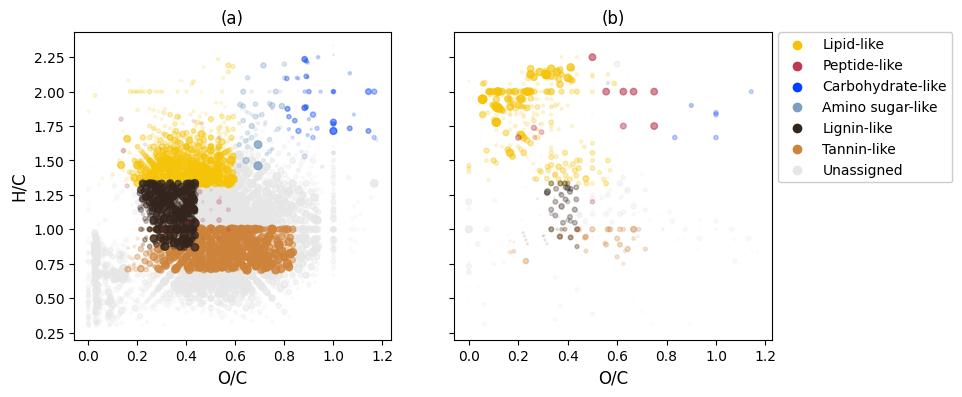

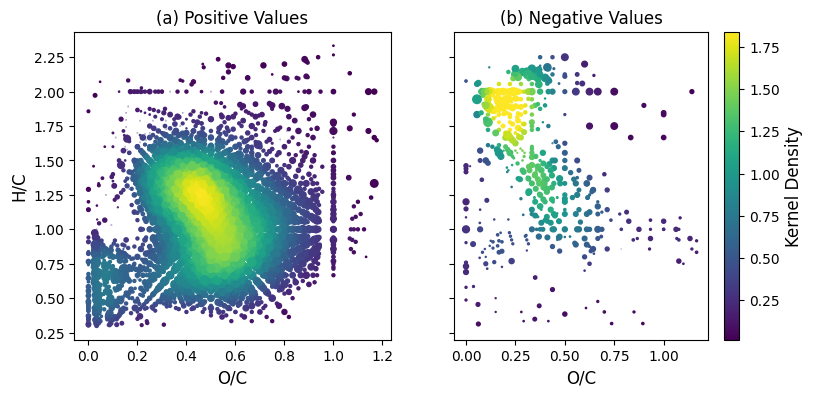

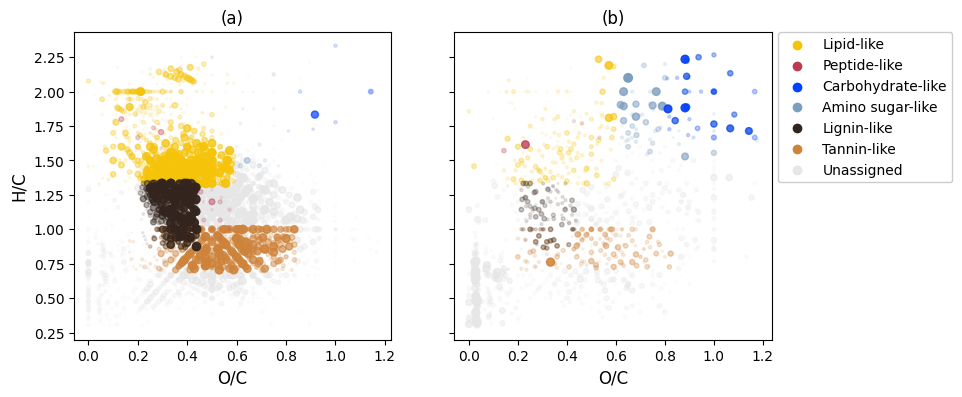

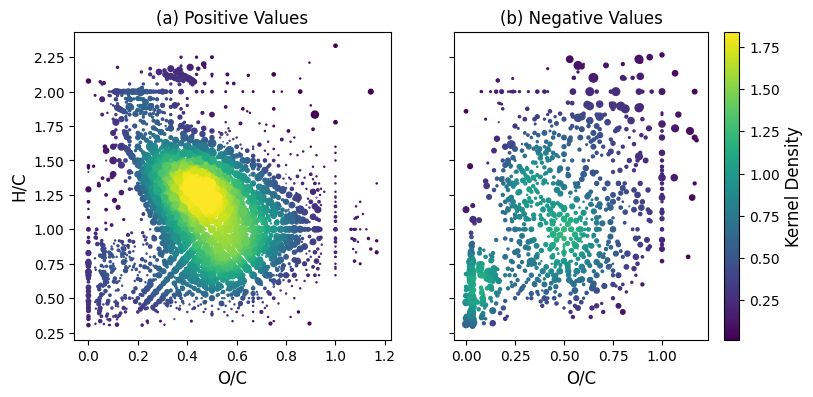

In [32]:
for PCo in chosen_PCos:
    change_vk_loadings(loadings,[PCo],elems_df,
                       moleclass_title='',
                       kde_title='',
                       moleclass_save=f'plots/pcoa_plots/vk_2loadings_molecclass_pco{PCo}.svg',
                       kde_save=f'plots/pcoa_plots/vk_2loadings_kd_pco{PCo}.svg')

144

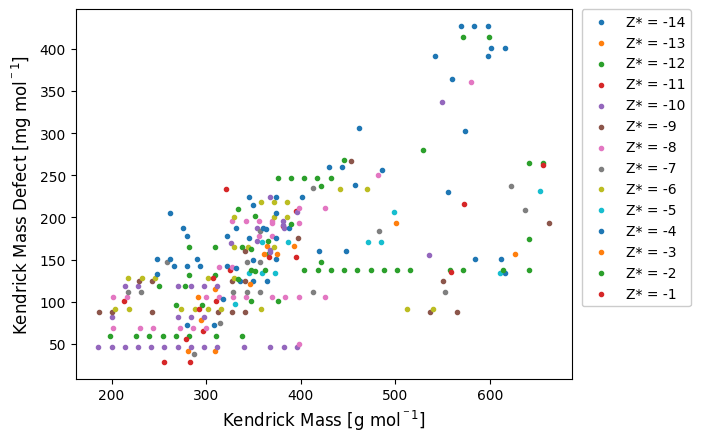

In [33]:
# lipids that change
thresh = 0
neg_idx = np.where((loadings[:,1]<thresh*np.min(loadings[:,1]))|
                   (((loadings[:,0]<thresh*np.min(loadings[:,0]))&(loadings[:,0]<thresh*np.min(loadings[:,0])))))

# lipids_idx = loadings[:,0][np.where(loadings[:,0]<0)]

lipids_df = msf.molecclass(elems_df.loc[neg_idx])['Lipid-like']
sat_lipids_df = lipids_df[(lipids_df['H/C']>1.6)]

kmass, kmd, z_stars = msf.kendrick_analysis(sat_lipids_df[['C','H','N','O','S']])
# for z in z_stars:
msf.kendrick_plot(kmass.values,kmd.values,z_stars.values,
                  title='',
                  save_path=f'plots/pcoa_plots/km_lipids.svg')
kmd_unique = np.unique(kmd)
len(kmd_unique)

In [34]:
kmd_groups = [y for y in [kmass.values[np.where(kmd.values==x)] for x in kmd_unique]]
min_kmasses = np.array([np.min(x) for x in kmd_groups])
kmd_groups_len = np.array([len(x) for x in kmd_groups])

sat_lipids_form = sat_lipids_df['formulae'].values
lipids_start_form = np.array([sat_lipids_df.loc[(kmd.values==x)&(kmass.values==y)]['formulae'].values[0] for x,y in zip(kmd_unique,min_kmasses)])
argsort = np.argsort(kmd_groups_len)
lipids_start_form = lipids_start_form[argsort]
lipids_start_form[-4]

np.str_('C12H22O2')

In [35]:
# for mclass in molecclass_dict:
#     idx = list(molecclass_dict[mclass].index)
#     # molecs = [msf.LatexMolecFormula(x) for x in molecclass_dict[mclass]['formulae'].to_list()]
#     fig_mclass = plt.figure()
#     ax_mclass = fig_mclass.subplots(len(chosen_PCos),sharex=True)
    
#     pcf.loadings_plot(np.arange(len(idx)),loadings[idx],chosen_PCos,linestyle='',ax=ax_mclass,fig=fig_mclass,
#                       marker='o',text_rotation=90,title=f'Loadings Plots for {mclass}')

In [36]:
sum_norm_ord_table_HM = sum_norm_ord_table_arr[np.where(sample_info['Site'] == 'HM')]
ord_table_arr_HM = ord_table_arr[np.where(sample_info['Site'] == 'HM')]
seasons_HM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('HM-')])
sum_norm_ord_table_AM = sum_norm_ord_table_arr[np.where(sample_info['Site'] == 'AM')]
ord_table_arr_AM = ord_table_arr[np.where(sample_info['Site'] == 'AM')]
seasons_AM = np.array([x.split('-')[-1] for x in sample_names if x.startswith('AM-')])

BC_matrix_HM = BrayCurtis_diss_matr(sum_norm_ord_table_HM)
BC_matrix_AM = BrayCurtis_diss_matr(sum_norm_ord_table_AM)

In [37]:
eigvals_HM, _, loadings_HM, coordinates_HM, proportion_explained_HM = mvf.PCoA(BC_matrix_HM,ord_table_arr_HM,number_of_dimensions=5)
eigvals_AM, _, loadings_AM, coordinates_AM, proportion_explained_AM = mvf.PCoA(BC_matrix_AM,ord_table_arr_AM,number_of_dimensions=5)

In [38]:
D = BC_matrix_HM.copy()
W = mvf.double_centering(D)
eigvals, eigvecs = la.eigh(W)

if np.any(eigvals < 0):
    c1 = np.max(np.abs(eigvals[np.where(eigvals<0)]))
    for i in range(np.shape(D)[0]):
        for j in range(np.shape(D)[1]):
            if i != j: D[i,j] = np.sqrt(np.pow(D[i,j],2)+(2*c1))
    W = mvf.double_centering(D)
    eigvals, eigvecs = la.eigh(W)

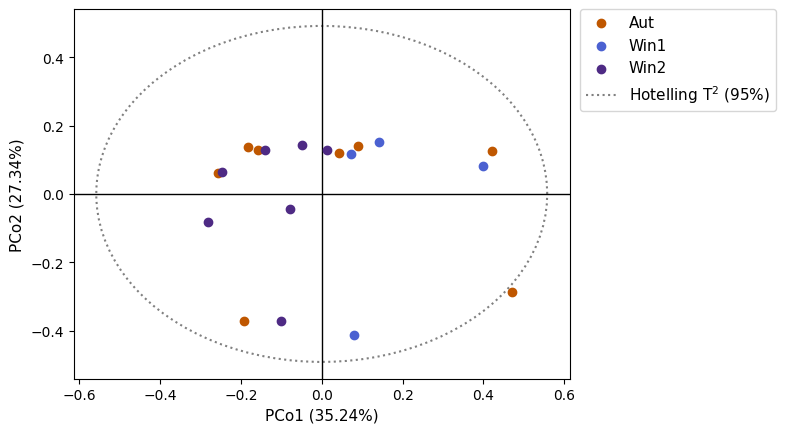

In [39]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_HM):

    idx = np.where(seasons_HM == season)

    pcf.scores_plot(coordinates_HM[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape['Hare Moss'],
                    c=seasonal_colours[season],label=season)
        
pcf.Hotelling(coordinates_HM,chosen_PCos,ax_scores,zorder=-1)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained_HM[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained_HM[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig('plots/pcoa_plots/hm_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')


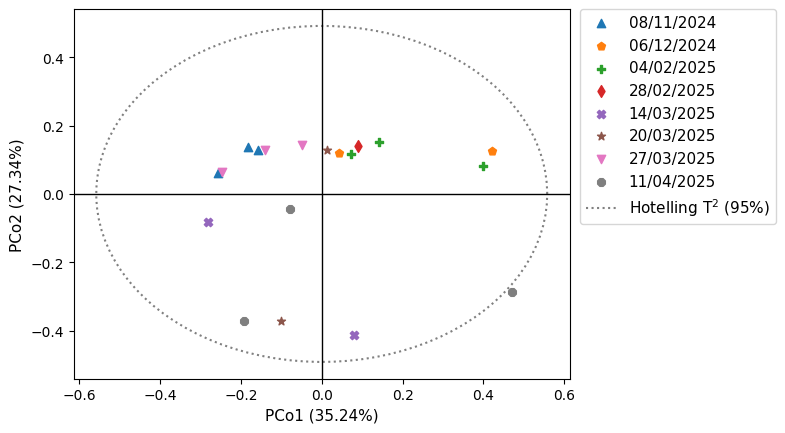

In [40]:
fig_scores, ax_scores = plt.subplots()
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'][np.where(sample_info['Site'] == 'HM')] == sorted_dates[i]))
    pcf.scores_plot(coordinates_HM[idx],chosen_PCos,lines=False,ax=ax_scores,label=sorted_dates[i],marker=datemarkers[i])

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained_HM[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained_HM[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(coordinates_HM,chosen_PCos,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig('plots/pcoa_plots/hm_scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

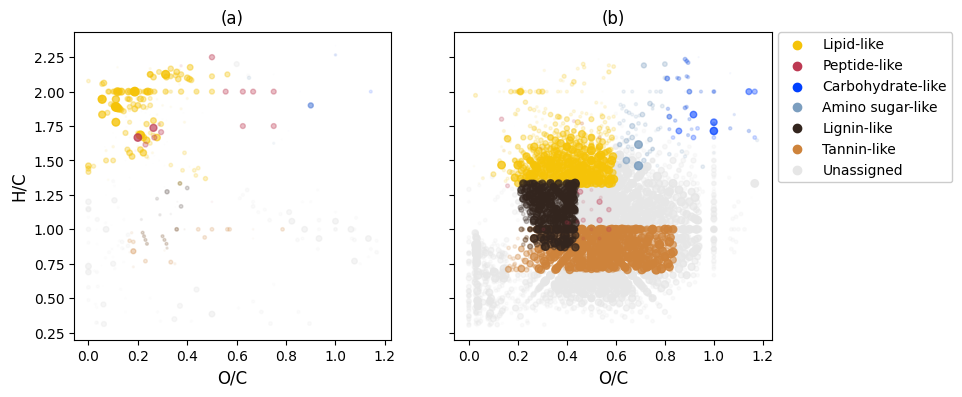

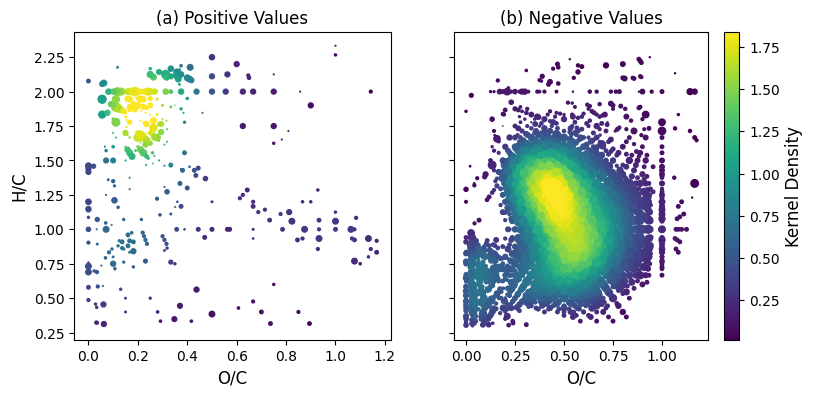

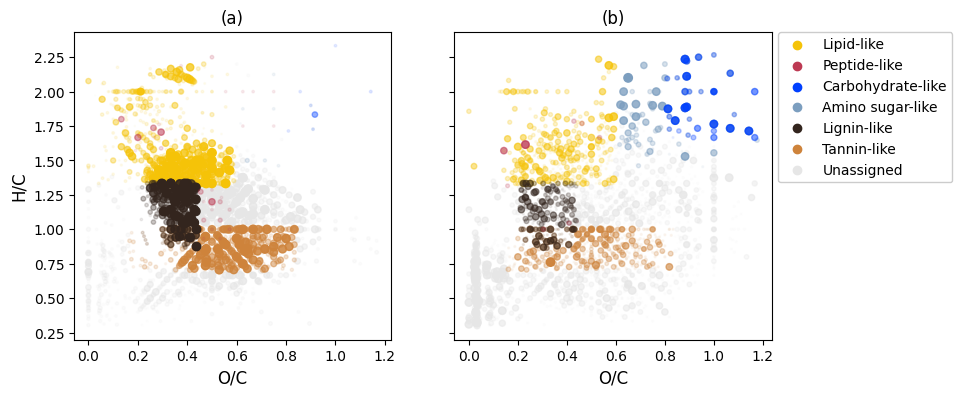

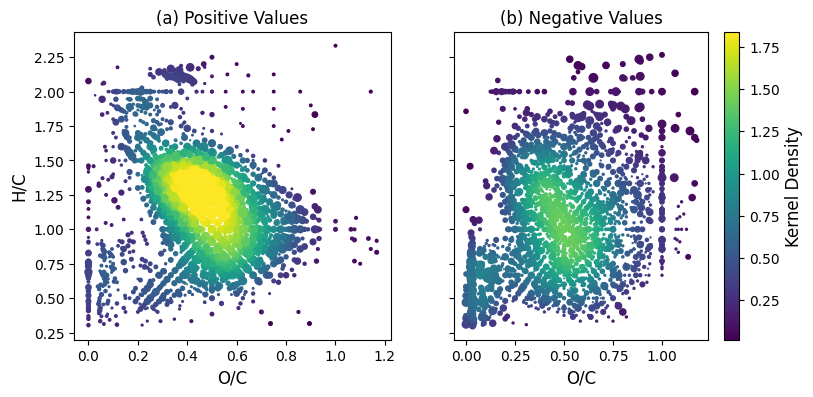

In [41]:
for PCo in chosen_PCos:
    change_vk_loadings(loadings_HM,[PCo],elems_df,
                       moleclass_title='',
                       kde_title='',
                       moleclass_save=f'plots/pcoa_plots/hm_vk_2loadings_molecclass_pco{PCo}.svg',
                       kde_save=f'plots/pcoa_plots/hm_vk_2loadings_kd_pco{PCo}.svg')

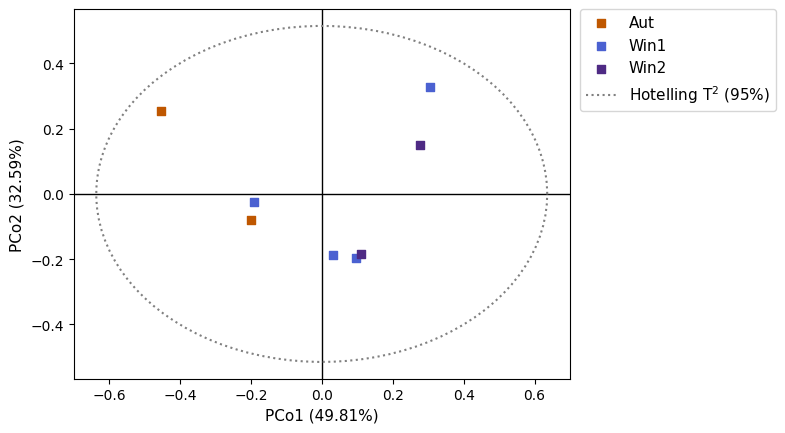

In [42]:
fig_scores, ax_scores = plt.subplots()

for season in np.unique(seasons_AM):

    idx = np.where(seasons_AM == season)

    pcf.scores_plot(coordinates_AM[idx],chosen_PCos,lines=False,ax=ax_scores,marker=m_shape['Auchencorth Moss'],
                    c=seasonal_colours[season],label=season)
        
pcf.Hotelling(coordinates_AM,chosen_PCos,ax_scores)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained_AM[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained_AM[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=15)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig('plots/pcoa_plots/am_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

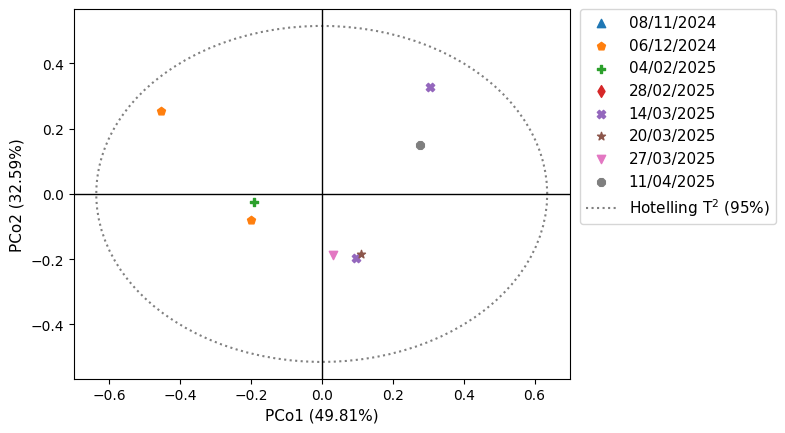

In [43]:
fig_scores, ax_scores = plt.subplots()
for i in range(len(sorted_dates)):
    idx = np.where((sample_info['date'][np.where(sample_info['Site'] == 'AM')] == sorted_dates[i]))
    pcf.scores_plot(coordinates_AM[idx],chosen_PCos,lines=False,ax=ax_scores,label=sorted_dates[i],marker=datemarkers[i])

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained_AM[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained_AM[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.set_title('',fontsize=15)
pcf.Hotelling(coordinates_AM,chosen_PCos,ax_scores,zorder=-1)
ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)
fig_scores.savefig('plots/pcoa_plots/am_scores_bydate.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

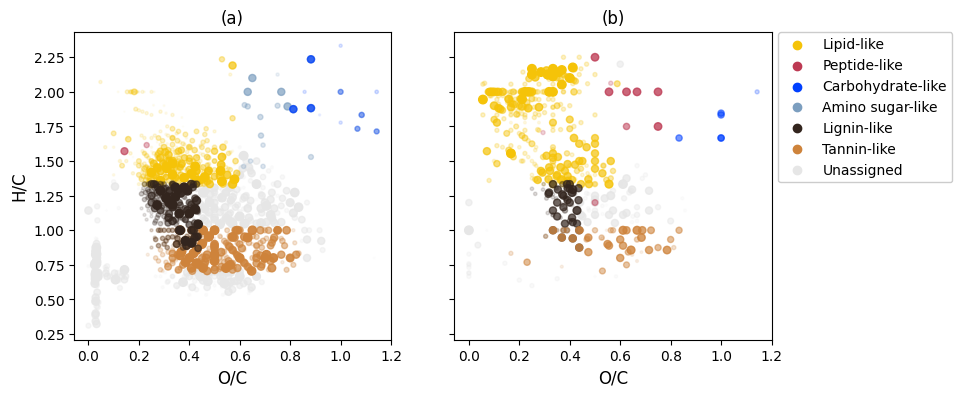

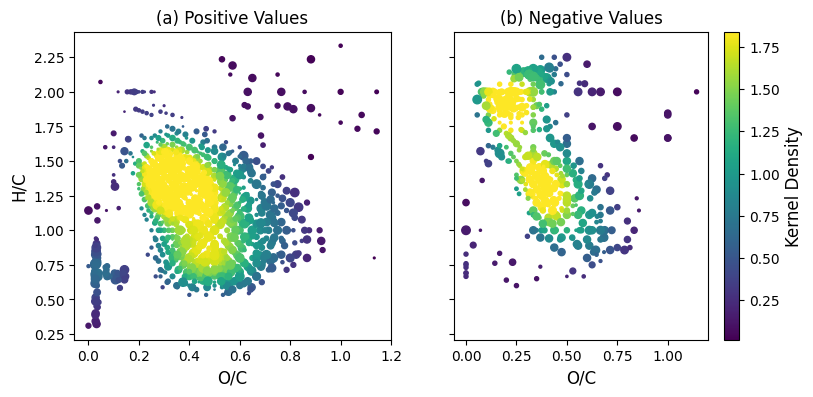

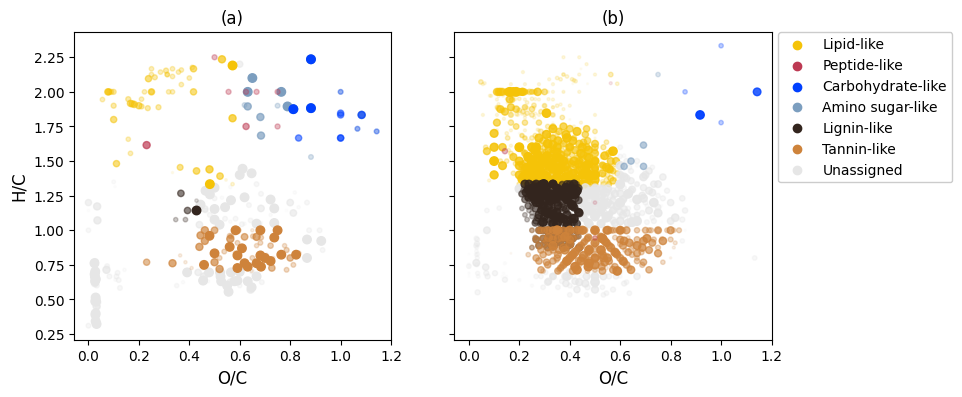

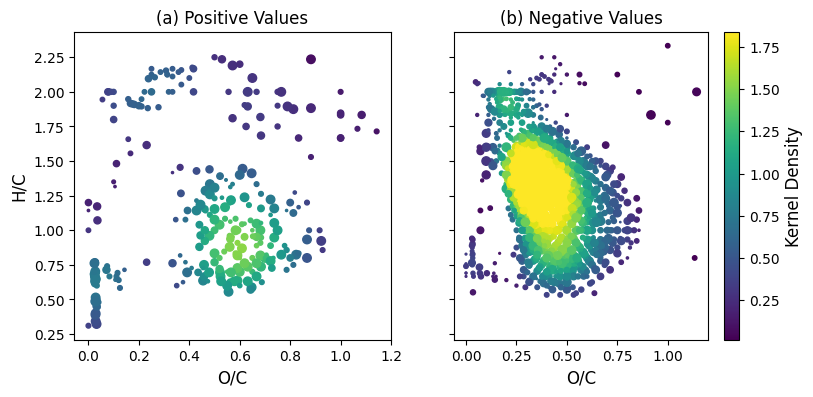

In [44]:
for PCo in chosen_PCos:
    change_vk_loadings(loadings_AM,[PCo],elems_df,
                       moleclass_title='',
                       kde_title='',
                       moleclass_save=f'plots/pcoa_plots/am_vk_2loadings_molecclass_pco{PCo}.svg',
                       kde_save=f'plots/pcoa_plots/am_vk_2loadings_kd_pco{PCo}.svg')

# SRFA PCoA

In [45]:
SRFA_ord_table_df = SRFA_ord_table_df.fillna(0)
# SRFA_ord_table_df[SRFA_ord_table_df>0] = 1
SRFA_ord_table_arr = SRFA_ord_table_df.to_numpy()
if binary:
    SRFA_ord_table_arr[np.where(SRFA_ord_table_arr>0)] = 1
if normalise:
    SRFA_ord_table_arr = mvf.standardise(SRFA_ord_table_arr)

SRFA_dates = np.array(SRFA_dates)

In [46]:
srfa_sum = np.sum(SRFA_ord_table_arr,axis=1)
srfa_sum = np.reshape(srfa_sum,(len(srfa_sum),1))
srfa_highest_peak = np.max(SRFA_ord_table_arr,axis=1)
srfa_highest_peak = np.reshape(srfa_highest_peak,(len(srfa_highest_peak),1))

sum_norm_ord_table_arr = SRFA_ord_table_arr / srfa_highest_peak # or /sample_sum

srfa_bc = BrayCurtis_diss_matr(sum_norm_ord_table_arr)

In [47]:
eigvals_srfa, _, loadings_srfa, coordinates_srfa, proportion_explained_srfa = mvf.PCoA(srfa_bc,SRFA_ord_table_df,number_of_dimensions=5)

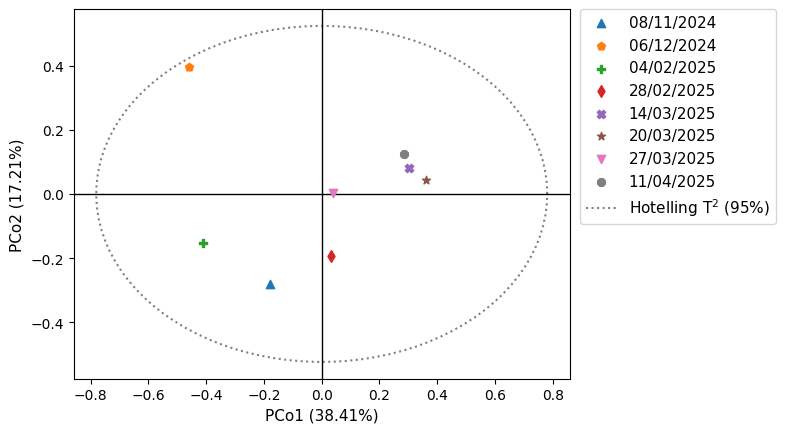

In [48]:
fig_scores, ax_scores = plt.subplots()

for i in range(len(sorted_dates)):

    pcf.scores_plot(coordinates_srfa[np.where(np.array(SRFA_dates==sorted_dates[i]))],
                    chosen_PCos,ax=ax_scores,title='',lines=None,
                    label=sorted_dates[i],marker=datemarkers[i])

pcf.Hotelling(coordinates_srfa,chosen_PCos,ax=ax_scores,zorder=-1)

ax_scores.set_xlabel(f'PCo{chosen_PCos[0]} ({np.round(proportion_explained_srfa[chosen_PCos[0]-1]*100,2)}%)',fontsize=11)
ax_scores.set_ylabel(f'PCo{chosen_PCos[1]} ({np.round(proportion_explained_srfa[chosen_PCos[1]-1]*100,2)}%)',fontsize=11)

ax_scores.axhline(y=0, color = '#000', linewidth = 1, zorder=-1)
ax_scores.axvline(x=0, color = '#000', linewidth = 1, zorder=-1)

fig_scores.savefig('plots/pcoa_plots/scores_srfa.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [49]:
srfa_forms = np.array(loadings_srfa.index)
elems_srfa = {'C':[],'H':[],'N':[],'O':[],'S':[]}
for f in srfa_forms:
    e_dict_f = msf.MolecFormulaDict(f)
    for e in elems_srfa:
        if e in e_dict_f:
            elems_srfa[e].append(e_dict_f[e])
        else:
            elems_srfa[e].append(0)

In [50]:
elems_srfa_df = pd.DataFrame(elems_srfa)
elems_srfa_df['formulae'] = srfa_forms
elems_srfa_df['H/C'] = elems_srfa_df['H'] / elems_srfa_df['C']
elems_srfa_df['O/C'] = elems_srfa_df['O'] / elems_srfa_df['C']

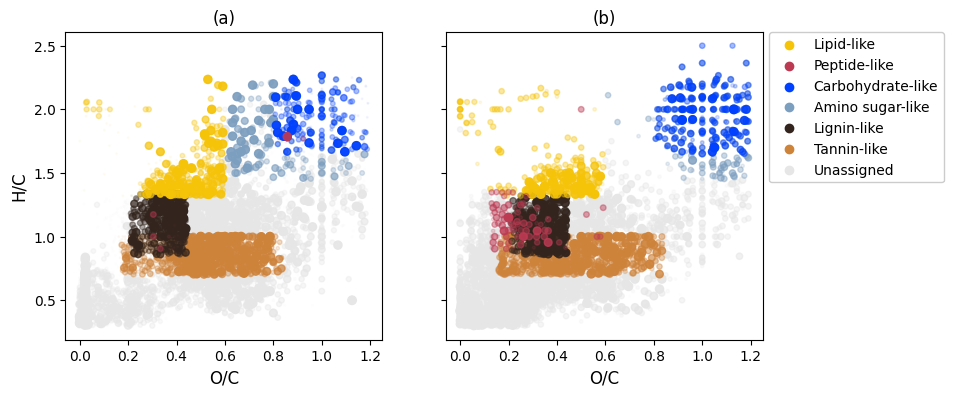

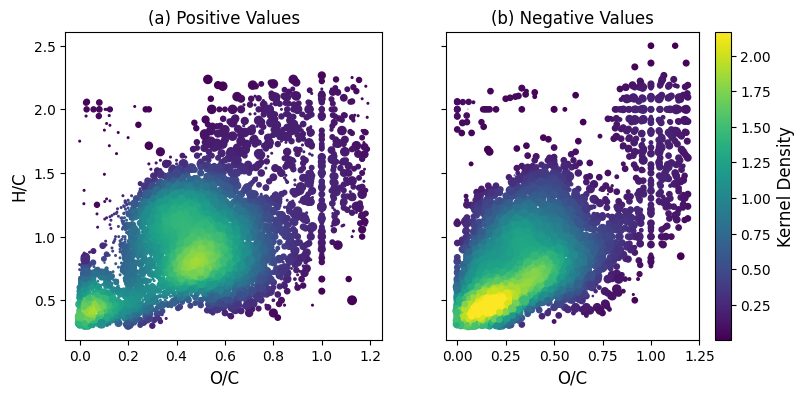

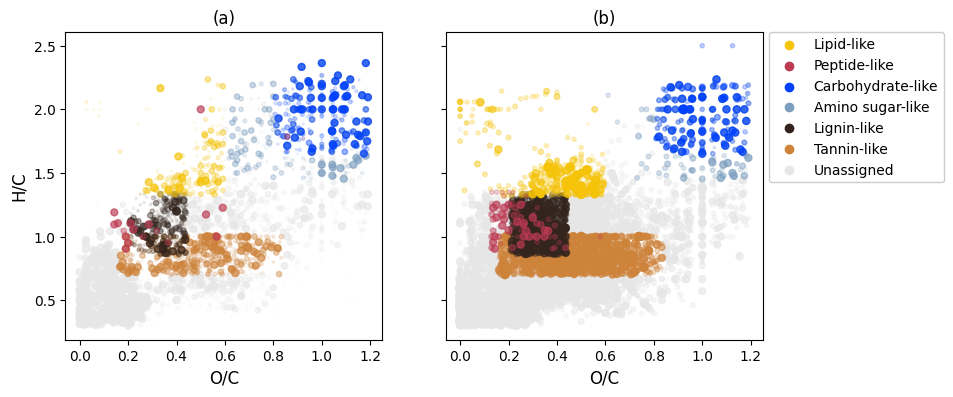

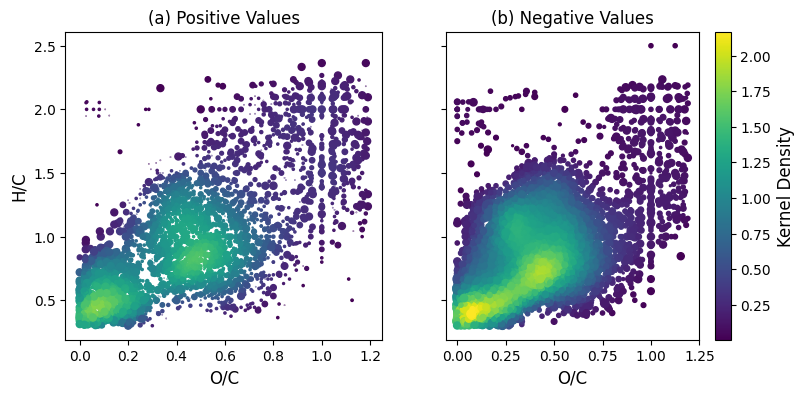

In [51]:
for PCo in chosen_PCos:
    change_vk_loadings(loadings_srfa.to_numpy(),[PCo],elems_srfa_df,
                       moleclass_title='',
                       kde_title='',
                       moleclass_save=f'plots/pcoa_plots/vk_2loadings_molecclass_pco{PCo}_srfa.svg',
                       kde_save=f'plots/pcoa_plots/vk_2loadings_kd_pco{PCo}_srfa.svg')